In [1]:
import numpy as np
import pandas as pd

from preprocessor import Preprocessor
from clusterer import Clusterer
from model import ForecastDataset, ForecastModel, LSTM
from forecaster import ClusterForecaster, WorkloadGenerator

from matplotlib import pyplot as plt

### Generate sine wave time series

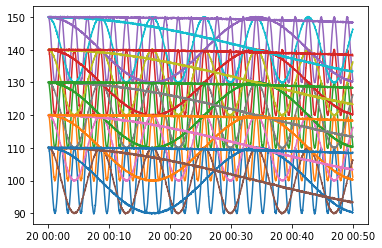

In [12]:
cluster_interval = pd.Timedelta(seconds=1)


def generate_cos_df(index, freq, amp, base, noise=0.0):
    n = len(index)
    wave = np.cos(np.arange(n) * 2 * np.pi / freq)
    wave += np.random.normal(size=n) * noise
    return pd.DataFrame(
        wave * amp + base,
        index=index, columns=['count'])


NUM_CLUSTERS = 5
TEMPLATE_PER_CLUSTER = 5
dtindex = pd.date_range(start="2021-12-20", end="2021-12-21",
                        freq=cluster_interval, name='log_time_s')

synthetic_templates = []

for i in range(NUM_CLUSTERS):
    for j in range(TEMPLATE_PER_CLUSTER):
        freq = 128*(4**i)
        amp = 10
        base = (j) * 10 + 100
        generated = generate_cos_df(dtindex, freq, amp, base, 0.01)

        plt.plot(generated.iloc[:3000])

        generated['query_template'] = "TEMPLATE_{}_{}".format(i, j)
        synthetic_templates.append(generated)

synthetic_groups = pd.concat(synthetic_templates).groupby(
    ["query_template", "log_time_s"]).sum()

plt.show()


### Clustering

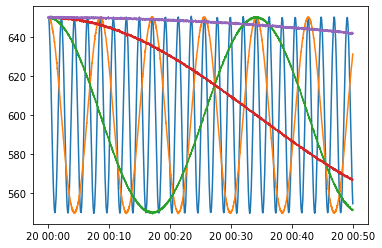

In [14]:
clusterer = Clusterer(synthetic_groups,rho=0.999,n_samples=1000)
assignment_df = clusterer.assignment_df

joined = synthetic_groups.join(assignment_df)
joined["cluster"].fillna(-1,inplace=True)
clustered_df = joined.groupby(["cluster", "log_time_s"]).sum()
cluster_dict = {}

labels = set(clustered_df.index.get_level_values(0).values)
for i in labels:
    cluster_counts = clustered_df[clustered_df.index.get_level_values(0)==i].droplevel(0).reindex(dtindex,fill_value=0)
    plt.plot(cluster_counts[:3000])
    cluster_dict[i] = cluster_counts

plt.show()

### Train Forecast Models

In [16]:
pred_seqlen = 10
pred_interval = pd.Timedelta(seconds = 10)
pred_horizon = pd.Timedelta(seconds = 60)

forecaster = ClusterForecaster(clustered_df, cluster_interval, pred_seqlen, pred_interval, pred_horizon, "sine_models")

Loaded 0 models
Training on cluster time series..
training model for cluster 0
Training with 8641 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00003582
[LSTM FIT]epoch:   2 loss: 0.00000229
[LSTM FIT]epoch:   3 loss: 0.00002579
[LSTM FIT]epoch:   4 loss: 0.00000132
[LSTM FIT]epoch:   5 loss: 0.00001623
[LSTM FIT]epoch:   6 loss: 0.00000034
[LSTM FIT]epoch:   7 loss: 0.00000595
[LSTM FIT]epoch:   8 loss: 0.00000318
[LSTM FIT]epoch:   9 loss: 0.00000302
[LSTM FIT]epoch:  10 loss: 0.00097025
[LSTM FIT]epoch:  10 loss: 0.0009702472
training model for cluster 1
Training with 8641 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00002201
[LSTM FIT]epoch:   2 loss: 0.00000283
[LSTM FIT]epoch:   3 loss: 0.00002519
[LSTM FIT]epoch:   4 loss: 0.00000723
[LSTM FIT]epoch:   5 loss: 0.00000197
[LSTM FIT]epoch:   6 loss: 0.00000351
[LSTM FIT]epoch:   7 loss: 0.00000197
[LSTM FIT]epoch:   8 loss: 0.00000410
[LSTM FIT]epoch:   9 loss: 0.00000016
[LSTM FIT]epoch:  10 loss: 0.00000038
[LSTM FIT]epoc

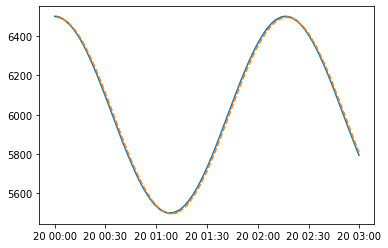

In [17]:
start_time = pd.Timestamp('2021-12-20 00:00:00')
end_time = pd.Timestamp('2021-12-20 03:00:00')
cluster = 3

result = forecaster.predict(clustered_df, cluster, start_time, end_time)

expected = clustered_df[clustered_df.index.get_level_values(0) == cluster].droplevel(0).resample(pred_interval).sum()
expected = expected[start_time:(end_time - pd.Timedelta(milliseconds = 1))]

plt.plot(expected)
plt.plot(result, "--")
plt.show()


### Workload Generation
Using sample tpcc data

In [2]:
import importlib
import forecaster
importlib.reload(forecaster)
from forecaster import ClusterForecaster, WorkloadGenerator

In [3]:
import glob
from pathlib import Path

query_log_folder = "/home/mkpjnx/repos/QueryBot5000/data/extracted/long_simple/"
pgfiles = glob.glob(str(Path(query_log_folder) / "postgresql*.csv"))

query_log_folder = "/home/mkpjnx/repos/QueryBot5000/data/extracted/tiramisu-sample/"
pgfiles = glob.glob(str(Path(query_log_folder) / "*"))
preprocessor = Preprocessor(pgfiles)
preprocessor.get_dataframe().to_parquet("tiramisu.parquet.gzip", compression="gzip")

ValueError: Invalid file path or buffer object type: <class 'list'>

In [86]:
model_path = "models"

cluster_interval = pd.Timedelta(seconds=1)
df = preprocessor.get_grouped_dataframe_interval(cluster_interval)

df.index.rename(["query_template", "log_time_s"], inplace=1)

print("Clustering query templates.")
clusterer = Clusterer(df, clusterer_interval=cluster_interval)
assignment_df = clusterer.assignment_df

# join to cluster and group by
joined = df.join(assignment_df)
joined["cluster"].fillna(-1, inplace=True)
clustered_df = joined.groupby(["cluster", "log_time_s"]).sum()


Clustering query templates.


In [87]:
# only train with the top 5 clusters
TOP_K_CLUSTERS = 5
cluster_totals = clustered_df.groupby(level=0).sum().sort_values(by='count', ascending=False)
cluster_totals = cluster_totals / cluster_totals.sum()
clustered_df = clustered_df.loc[cluster_totals.index[:TOP_K_CLUSTERS],:]
cluster_totals.cumsum().iloc[:TOP_K_CLUSTERS]

In [109]:
len(cluster_totals)

39

In [89]:
pred_interval = pd.Timedelta(seconds=5)
pred_horizon = pd.Timedelta(seconds=120)

forecaster = ClusterForecaster(
    clustered_df,
    cluster_interval=cluster_interval,
    prediction_seqlen=30,
    prediction_interval=pred_interval,
    prediction_horizon=pred_horizon,
    save_path=model_path)

Loaded 0 models
Training on cluster time series..
training model for cluster 0
Training with 375 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00003520
[LSTM FIT]epoch:   2 loss: 0.00329471
[LSTM FIT]epoch:   3 loss: 0.11720879
[LSTM FIT]epoch:   4 loss: 0.00849191
[LSTM FIT]epoch:   5 loss: 0.00308684
[LSTM FIT]epoch:   6 loss: 0.00031785
[LSTM FIT]epoch:   7 loss: 1.44465959
[LSTM FIT]epoch:   8 loss: 0.59274024
[LSTM FIT]epoch:   9 loss: 0.20907067
[LSTM FIT]epoch:  10 loss: 0.01335385
[LSTM FIT]epoch:  10 loss: 0.0133538507
training model for cluster 2
Training with 375 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00042772
[LSTM FIT]epoch:   2 loss: 0.00077828
[LSTM FIT]epoch:   3 loss: 0.00000033
[LSTM FIT]epoch:   4 loss: 0.00000668
[LSTM FIT]epoch:   5 loss: 0.00000000
[LSTM FIT]epoch:   6 loss: 0.00000011
[LSTM FIT]epoch:   7 loss: 0.00000015
[LSTM FIT]epoch:   8 loss: 0.00000320
[LSTM FIT]epoch:   9 loss: 0.00000006
[LSTM FIT]epoch:  10 loss: 0.00000000
[LSTM FIT]epoch:

In [90]:
min_time = clustered_df.index.get_level_values(1).min()
max_time = clustered_df.index.get_level_values(1).max()

In [114]:
# predict over a 1 minute interval
pred_start = max_time
pred_end = max_time + pd.Timedelta(seconds = 30)

In [115]:
cluster = 0

result = forecaster.predict(clustered_df, cluster, pred_start, pred_end)

expected = clustered_df[clustered_df.index.get_level_values(0) == cluster].droplevel(0).resample(pred_interval).sum()
expected = expected[pred_start:(pred_end - pd.Timedelta(milliseconds = 1))]

result
# plt.plot(expected)
# plt.plot(result, "--")
# plt.show()


,count
log_time_s,
2021-12-26 13:33:00-05:00,15578.477094
2021-12-26 13:33:05-05:00,15502.538148
2021-12-26 13:33:10-05:00,15393.164894
2021-12-26 13:33:15-05:00,15254.203999


In [113]:
max_time

Timestamp('2021-12-26 13:32:59-0500', tz='pytz.FixedOffset(-300)')

In [101]:
wg = WorkloadGenerator(preprocessor, assignment_df, cluster_interval)

In [83]:
workload = wg.get_workload(cluster, result['count'].sum())

In [84]:
workload

query
SELECT S_QUANTITY, S_DATA, S_DIST_01, S_DIST_02, S_DIST_03, S_DIST_04, S_DIST_05, S_DIST_06, S_DIST_07, S_DIST_08, S_DIST_09, S_DIST_10 FROM stock WHERE S_I_ID = 35743 AND S_W_ID = 1 FOR UPDATE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    189645
SELECT I_PRICE, I_NAME , I_DATA FROM item WHERE I_ID = 77463                                                                                                                                                                                                                                                                          